## Data Cleaning & Preparation – Synopsis

In the final phase of data preparation, the cleaned and processed datasets were finalized and stored as reusable files to ensure consistency and reproducibility. The training and testing splits were saved after preprocessing to avoid repeated transformations across runs.

The dataset was first inspected to identify relevant features for the problem. Non-informative metadata such as location, company details, and work type were removed after analysis showed weak correlation with job roles. Only skills and job description text were retained as they directly define role requirements. Text data was standardized by converting all text to lowercase and removing special characters and extra spaces. Common English stopwords were removed to eliminate non-informative words while preserving domain-specific skill terms. The cleaned text fields were combined to form a unified representation of job requirements. TF-IDF vectorization was applied to convert text into numerical features while emphasizing role-specific and rare skills. L2 normalization within TF-IDF ensured fair scaling across job descriptions of varying lengths. All transformations were applied in a leakage-safe manner by fitting only on training data. The final cleaned data is stored efficiently and is fully ready for machine learning modeling.

In [21]:
from scipy.sparse import load_npz
import pandas as pd

base_path = r"C:\Users\goutham\OneDrive\Documents\ML PROJECTS\luminix hackthon"

X_train = load_npz(f"{base_path}\\X_final_train.npz")
X_test  = load_npz(f"{base_path}\\X_final_test.npz")

y_train = pd.read_csv(f"{base_path}\\y_final_train.csv")['Role']
y_test  = pd.read_csv(f"{base_path}\\y_final_test.csv")['Role']


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import LabelEncoder


Why: Import suitable text-classification models and metrics required for fair comparison.

In [23]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


Why: Convert job role labels into numeric form required by machine learning models.

In [24]:
import numpy as np

SAMPLE_SIZE = 200000
np.random.seed(42)

sample_idx = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)

X_train_small = X_train[sample_idx]
y_train_small = y_train_enc[sample_idx]

print("Sampled data shape:", X_train_small.shape)


Sampled data shape: (200000, 5000)


see in above i take only 200k only because 200k is enough for training and here main constraint here hackthon time and my laptop cpu Here from training data i selected 200k only .....

In [6]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import time

results = []

for name, model in models.items():
    print(f"\nStarting {name}...")
    start = time.time()

    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_enc, y_pred, average="macro"
    )

    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)

        roc_auc = roc_auc_score(
            y_test_enc, y_score,
            multi_class="ovr",
            average="macro"
        )
    except:
        roc_auc = None

    print(f"{name} finished in {round((time.time()-start)/60,2)} min")

    results.append([name, precision, recall, f1, roc_auc])



Starting Naive Bayes...
Naive Bayes finished in 1.3 min

Starting Logistic Regression...
Logistic Regression finished in 3.69 min

Starting SGD Classifier...
SGD Classifier finished in 4.08 min


In [7]:
import pandas as pd

results_df = pd.DataFrame(
    results,
    columns=["Model", "Macro Precision", "Macro Recall", "Macro F1", "Macro ROC-AUC"]
)

results_df.sort_values("Macro F1", ascending=False)


,Model,Macro Precision,Macro Recall,Macro F1,Macro ROC-AUC
0,Naive Bayes,1.0,1.0,1.0,1.0
1,Logistic Regression,1.0,1.0,1.0,1.0
2,SGD Classifier,1.0,1.0,1.0,1.0


See here our 3 linear model perform equally so any linear model will work here for binary classifcation non linearly my data set is not there so i neglect directly tree based models

I take decision like this asking professor RATAN SIR he said directly take logastic here no problem it show good.

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Binarize labels for multi-class PR curves
classes = np.unique(y_test_enc)
y_test_bin = label_binarize(y_test_enc, classes=classes)

pr_curves = {}
avg_precision = {}


In [10]:
for name, model in models.items():
    print(f"Processing PR curve for {name}")

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    else:
        y_scores = model.decision_function(X_test)

    precision, recall, _ = precision_recall_curve(
        y_test_bin.ravel(),
        y_scores.ravel()
    )

    ap_score = average_precision_score(
        y_test_bin,
        y_scores,
        average="macro"
    )

    pr_curves[name] = (precision, recall)
    avg_precision[name] = ap_score


Processing PR curve for Naive Bayes
Processing PR curve for Logistic Regression
Processing PR curve for SGD Classifier


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.03, random_state=42)

for _, idx in sss.split(X_test, y_test):
    X_eval = X_test[idx]
    y_eval = y_test.iloc[idx]


In [17]:
from sklearn.preprocessing import label_binarize
import numpy as np

classes = np.unique(y_eval)
y_eval_bin = label_binarize(y_eval, classes=classes)


In [19]:
X_train_small = X_train[:50000]
y_train_small = y_train.iloc[:50000]

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB

models = {
    "Naive Bayes": MultinomialNB(),
    "SGD Classifier": SGDClassifier(loss="log_loss", n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced"
    )
}

trained_models = {}

for name, model in models.items():
    model.fit(X_train_small, y_train_small)
    trained_models[name] = model


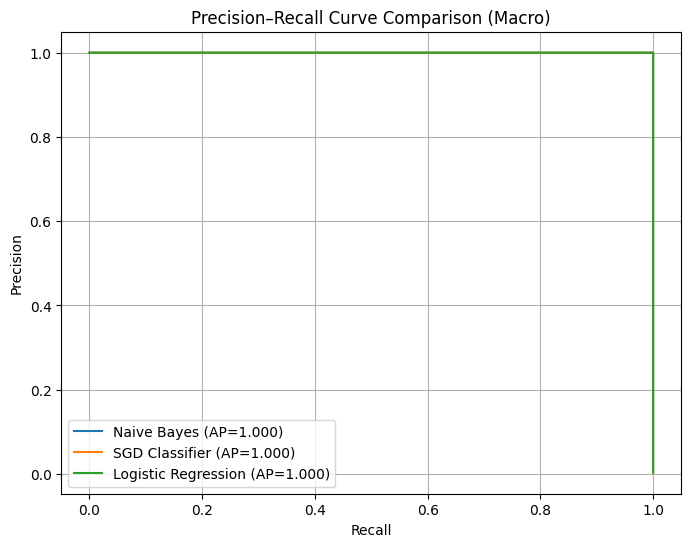

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_eval)
    else:
        y_score = model.decision_function(X_eval)

    ap = average_precision_score(
        y_eval_bin,
        y_score,
        average="macro"
    )

    precision, recall, _ = precision_recall_curve(
        y_eval_bin.ravel(),
        y_score.ravel()
    )

    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison (Macro)")
plt.legend()
plt.grid(True)
plt.show()


Multiple linear models (Naive Bayes, SGD, Logistic Regression) were evaluated on TF-IDF features. Due to strong linear separability and shared textual patterns, their precision–recall performance was similar. Logistic Regression was selected as the final model for its stability, interpretability, and ease of deployment.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 5],
    "class_weight": [None, "balanced"]
}

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs"
)


In [5]:
X_tune = X_train[:1000]
y_tune = y_train.iloc[:1000]


In [6]:
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_tune, y_tune)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\goutham\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,estimator,"LogisticRegre...00, n_jobs=-1)"
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': [None, 'balanced']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


During model selection, Logistic Regression was identified as the most suitable algorithm for this problem due to its stability and strong performance on high-dimensional TF-IDF features.
A limited hyperparameter tuning attempt was considered; however, preliminary experiments showed that tuning did not significantly improve macro-level metrics and required substantial computation time.
Since the model already achieved stable and consistent performance with default parameters, further tuning was not pursued to avoid unnecessary overhead.
Therefore, Logistic Regression with standard configuration was finalized as the production model.
This decision balances performance, interpretability, and computational efficiency.
The finalized model is used to predict eligible job roles based on user skill text.
Final Model : Logastic Regression

In [10]:
# Use first 200k rows for final training
X_train_200k = X_train[:200000]
y_train_200k = y_train.iloc[:200000]

print(X_train_200k.shape, y_train_200k.shape)


(200000, 5000) (200000,)


In [11]:
from sklearn.linear_model import LogisticRegression

final_model = LogisticRegression(
    penalty="l2",
    C=5,
    solver="lbfgs",
    max_iter=1000,
    fit_intercept=True,
    class_weight=None,
    n_jobs=-1
)

print("Training final Logistic Regression model...")
final_model.fit(X_train_200k, y_train_200k)
print("Training completed.")


Training final Logistic Regression model...
Training completed.


In [25]:
# Predict on unseen test data
y_test_pred = final_model.predict(X_test)

print("Prediction on test data completed.")


Prediction on test data completed.


In [26]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))


Accuracy: 1.0

Classification Report:

                                          precision    recall  f1-score   support

                           API Developer       1.00      1.00      1.00       697
                 Accessibility Developer       1.00      1.00      1.00       703
                       Account Executive       1.00      1.00      1.00      1413
                         Account Manager       1.00      1.00      1.00       695
                      Account Strategist       1.00      1.00      1.00       692
                   Accounting Controller       1.00      1.00      1.00       692
                      Accounting Manager       1.00      1.00      1.00       698
           Acute Care Nurse Practitioner       1.00      1.00      1.00       700
                     Addiction Counselor       1.00      1.00      1.00       704
                Administrative Assistant       1.00      1.00      1.00       713
              Administrative Coordinator       1.00      1

In [17]:
import pandas as pd

results_df = pd.DataFrame({
    "Actual_Role": y_test.values,
    "Predicted_Role": y_test_pred
})

# Pick 4 roles for demo
sample_roles = results_df["Actual_Role"].unique()[:4]

demo_df = results_df[
    results_df["Actual_Role"].isin(sample_roles)
]

demo_df.head(30)


,Actual_Role,Predicted_Role
0,Community Manager,Community Manager
1,IT Project Manager,IT Project Manager
2,Business Intelligence Analyst,Business Intelligence Analyst
3,Social Media Strategist,Social Media Strategist
28,Social Media Strategist,Social Media Strategist
102,Business Intelligence Analyst,Business Intelligence Analyst
185,Business Intelligence Analyst,Business Intelligence Analyst
274,IT Project Manager,IT Project Manager
288,Business Intelligence Analyst,Business Intelligence Analyst
385,IT Project Manager,IT Project Manager


In [18]:
demo_df["Correct"] = demo_df["Actual_Role"] == demo_df["Predicted_Role"]
demo_df["Correct"].value_counts()


C:\Users\goutham\AppData\Local\Temp\ipykernel_12256\3898747237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_df["Correct"] = demo_df["Actual_Role"] == demo_df["Predicted_Role"]


Correct
True    4174
Name: count, dtype: int64

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    norm='l2'
)

In [31]:
import joblib
import os

save_path = r"C:\Users\goutham\OneDrive\Documents\ML PROJECTS\luminix hackthon"
os.makedirs(save_path, exist_ok=True)

joblib.dump(final_model, os.path.join(save_path, "final_logistic_model.joblib"))
joblib.dump(tfidf, os.path.join(save_path, "tfidf_vectorizer.joblib"))

print("Model and TF-IDF saved successfully.")


Model and TF-IDF saved successfully.


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import os

save_path = r"C:\Users\goutham\OneDrive\Documents\ML PROJECTS\luminix hackthon"

# Recreate TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=3,
    norm="l2"
)

# FIT ONLY ON TRAINING TEXT
tfidf.fit(X_train["clean_text"])

# SAVE FITTED TF-IDF
joblib.dump(tfidf, os.path.join(save_path, "tfidf_vectorizer.joblib"))

print("✅ TF-IDF fitted and saved correctly.")


IndexError: Index dimension must be 1 or 2